In [1]:
# Imports
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
# Use GPU
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
        device = torch.device("cpu")
print("Using device:", device)

Using device: mps


# Data generation


In [3]:
from utils.generate_data import generate_data

In [4]:
# Parameters
batch_size = 50
n_train    = 40
n_test     = 40
d          = 6000
rho        = 5.0
eta        = 0.1
beta       = 0.025  

In [5]:
X_train_np, y_train_np, clean_indices_train, noisy_indices_train = generate_data(n_train, d, rho, eta= 0.1)
X_test_np,  y_test_np, clean_indices_test, noisy_indices_test = generate_data(n_test, d, rho, eta= 0.1)


X_train = torch.tensor(X_train_np, dtype=torch.float32, device=device)
y_train = torch.tensor(y_train_np, dtype=torch.float32, device=device)
X_test = torch.tensor(X_test_np, dtype=torch.float32, device=device)
y_test = torch.tensor(y_test_np, dtype=torch.float32, device=device)


X_train[clean_indices_train].shape

torch.Size([37, 2, 6000])

# Single head attention


In [6]:
range = 0.01

class SingleHeadAttention(nn.Module):
    """
    Implements f(X; p, v) = v^T X^T softmax(X p),
    where X is (batch_size, 2, d),
          p, v are (d,).
    """
    def __init__(self, d):
        super().__init__()
        # Initialization of p and v
        self.p = nn.Parameter(torch.randn(d) * range)
        self.v = nn.Parameter(torch.randn(d) * range)

    def forward(self, X):
        # Compute the raw "logits" for attention: X p
        logits = X @ self.p  # (batch_size, 2, d) @ (d,) -> (batch_size, 2)
        
        # Apply softmax across the two tokens (dim=1)
        attn_weights = F.softmax(logits, dim=1) #(batch_size, 2)
        
        # Compute the weighted sum of the 2 tokens:
        weighted_sum = (attn_weights.unsqueeze(-1) * X).sum(dim=1) # (batch_size, d)
        
        # Dot product with v for each sample
        output = (weighted_sum * self.v).sum(dim=1) # (batch_size,)

        return output



# Gradient Descent

### Training with Gradient Descent

In [7]:
from utils.train_model import train_with_gradient_descent

Epoch 1
Epoch 50
Epoch 100
Epoch 150
train_accs [0.01, 0.525, 0.975, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
clean_probs [0.5227089, 0.5407621, 0.5383678, 0.5286578, 0.51703143, 0.5026848, 0.48965788, 0.4827522, 0.47882453, 0.4765363, 0.47500178, 0.4738686, 0.47298366, 0.47226617, 0.47166872, 0.4711

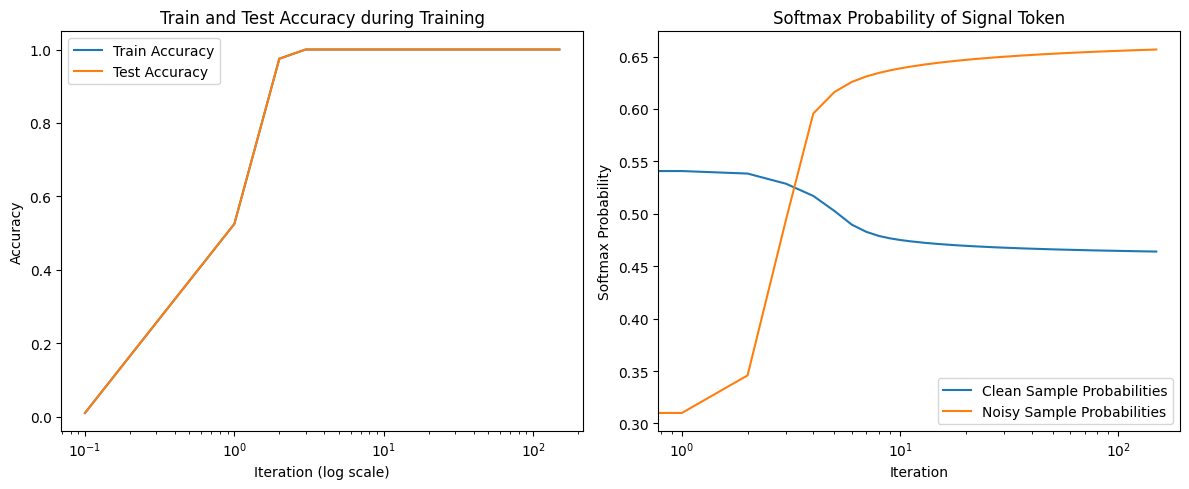

In [33]:
# Model and Optimizer
model_gradient_descent = SingleHeadAttention(d).to(device)
optimizer_gradient_descent = torch.optim.SGD(model_gradient_descent.parameters(), lr=beta)

model_with_gradient_descent = train_with_gradient_descent(model_gradient_descent, 
                                                          optimizer_gradient_descent, 
                                                          X_train, 
                                                          y_train, 
                                                          X_test, 
                                                          y_test, 
                                                          clean_indices_train, 
                                                          noisy_indices_train,
                                                          beta=beta)

### Max-Margin Solution

In [30]:
import importlib
import utils.train_model
importlib.reload(utils.train_model)
from utils.train_model import train_with_max_margin

In [31]:
# Parameters
r = np.sqrt(d)
R = np.sqrt(d)*0.1
margin_lambda = 1.0

Epoch 1
Epoch 50
Epoch 100
Epoch 150
train_accs [0.01, 1.0, 0.95, 0.875, 1.0, 1.0, 1.0, 1.0, 0.975, 0.95, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.975, 1.0, 0.975, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
clean_probs [0.4639545, 0.462901, 0.4529437, 0.41898227, 0.41968864, 0.41999352, 0.42015705, 0.41149202, 0.4155025, 0.4229814, 0.43297204, 0.4293157, 0.4290517, 0.42909747, 0.42910713, 

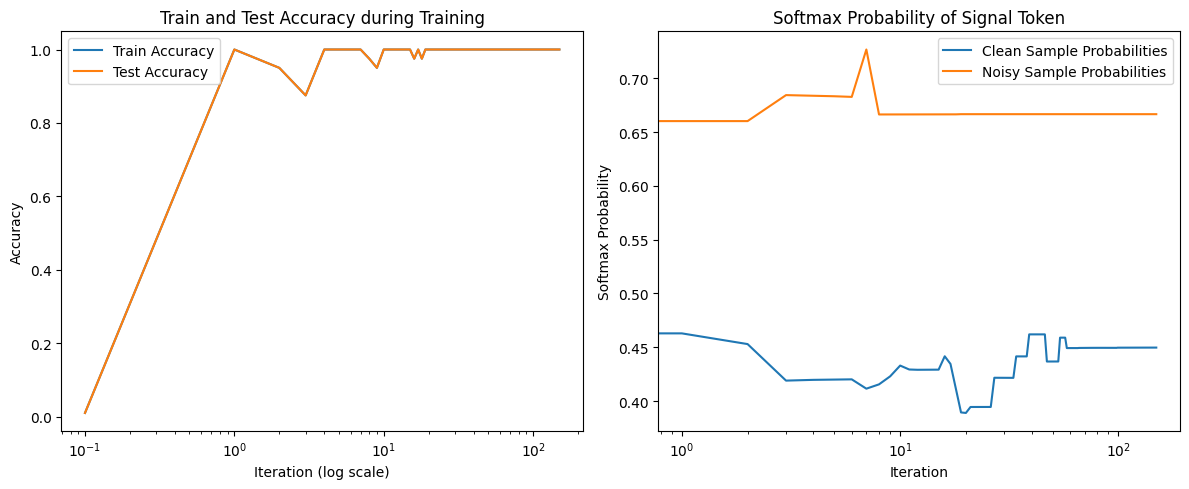

In [34]:
model_max_margin = SingleHeadAttention(d).to(device)
optimizer_max_margin = torch.optim.SGD(model_max_margin.parameters(), lr=beta)

model_max_margin = train_with_max_margin(model_gradient_descent, 
                                        optimizer_gradient_descent, 
                                        X_train, 
                                        y_train, 
                                        X_test, 
                                        y_test, 
                                        clean_indices_train, 
                                        noisy_indices_train, (r,R))